# Multivariate Exploratory Data Analysis: Combo Charts and Heat Maps
---
## Purpose:
In the last notebook (Univariate EDA) we explored basic distributions from our 3 datasets (EPA, USDA, and Redfin) to identify how are data is skewed at the county and state level. We also looked at the top and bottom 5 states for factors like emissions, income, and property values. <u>In this notebook, we will begin multivariate analysis to answer our project's core questions</u> which are listed below. 

1. Are factors of wealthy, population density, and inequality correlated with pollution levels?
2. Which areas generate the greatest residental pollution relative to local income? 
3. Which regions have the greatest residental pollution relative to their property values? 
4. How are pollution compositions stratified across sectors when we look at different groups of people? 


### Package Installation and Versioning Requirments:
For questions regarding python version, package installations, and other functional requirements, see the *Read Me* file contained [here](https://github.com/MDJonesBYU/Wealth_and_Pollution_Study/blob/main/Read_me/Read_me.txt).

Now, let's begin.

### Import Packages and Load Data

In [5]:
# Importing required packages: 
import matplotlib.pyplot as plt 
from sklearn.preprocessing import LabelEncoder
import seaborn as sns

# Importing py files
from Basic_data_structure_observations import *
from Data_manipulation import *
from Univariate_EDA import get_extremes
# Load the dataframes
global df_emissions, df_USDA, df_Redfin
df_emissions, df_USDA, df_Redfin = load_base_data()

# Clean the county-level dataframes, focusing on residential emissions
df_Redfin_County = Clean_Redfin(df_Redfin, "COUNTY")
df_USDA_County = Clean_USDA(df_USDA, "COUNTY")
df_emissions_County = Clean_EPA(df_emissions, "COUNTY", "residential", agg=True)

# Clean the state-level dataframes, focusing on residential emissions
df_Redfin_State = Clean_Redfin(df_Redfin, "STATE")
df_USDA_State = Clean_USDA(df_USDA, "STATE")
df_emissions_State = Clean_EPA(df_emissions, "STATE", "residential", agg=True)

# Get merged dataframes to work with 
df_merged_state = get_merge_df(df_emissions_State,df_USDA_State,df_Redfin_State, level="STATE")
df_merged_cty = get_merge_df(df_emissions_County,df_USDA_County,df_Redfin_County, level="COUNTY")

### Multivariate Analysis: Pollution to Income Ratio

in this segment, we're going to address the following questions:
* "Which areas generate the greatest residental pollution relative to local income?"
* "Which areas generate the greatest residental pollution relative to property value?"

In [6]:
# We'll start by creating a new emissions column, normalizing the region's emissions to the civilian labor force. 
# it's not a perfect match to the true population since it excludes children, elderly, and individuals with disabilities 
# that cannot work. However, we were limited to 3 datasets for this project, so we are assuming for now that the labor
# force is roughly the size of the population. 

# Normalize pollution at the person level, and convert from tons to lbs of CO emissions:
df_merged_state["Emissions per Person"] = df_merged_state["EMISSIONS"] / df_merged_state["Civilian_labor_force_2021"]*2e3
df_merged_cty["Emissions per Person"]   = df_merged_cty["EMISSIONS"]   / df_merged_cty["Civilian_labor_force_2021"]*2e3

# Now let's find the ratio of per-person CO pollution to income
df_merged_state["PI_ratio"] = df_merged_state["Emissions per Person"] / df_merged_state["Median_Household_Income_2021"]
df_merged_cty["PI_ratio"]   = df_merged_cty["Emissions per Person"]   / df_merged_cty["Median_Household_Income_2021"] 

# And let's snag the ratio of per-person CO pollution to property value
df_merged_state["PPV_ratio"] = df_merged_state["Emissions per Person"] / df_merged_state["median_sale_price"]
df_merged_cty["PPV_ratio"]   = df_merged_cty["Emissions per Person"]   / df_merged_cty["median_sale_price"] 

In [7]:
df_merged_state.head(2)

,STATE,STATE FIPS,EMISSIONS,Civilian_labor_force_2021,Median_Household_Income_2021,Unemployment_rate_2021,median_sale_price,state,Emissions per Person,PI_ratio,PPV_ratio
0,AL,01,406246,4518704.0,55206.166292,3.377170,200000.0,Alabama,179.806422,0.003257,0.000899
1,AK,02,249777,706316.0,79244.605215,6.409494,317350.0,Alaska,707.267002,0.008925,0.002229


In [38]:
# Next, to see the places with highest/lowest pollution to income and pollution to property values, we will call 
# the "get_extremes" function from our univariate analysis. 
county_extremes_PI = get_extremes(df_merged_cty, "PI_ratio")
county_extremes_PPV = get_extremes(df_merged_cty, "PPV_ratio")

state_extremes_PI = get_extremes(df_merged_state, "PI_ratio")
state_extremes_PPV = get_extremes(df_merged_state, "PPV_ratio")

# and let's go ahead and plot these to find out.  
def extremes_bar_plotter(dfs, fig_num):
    
    # Set the figure object, while providing a numpy array of axis (our 2x2 matrix)
    fig, axs = plt.subplots(2, 2, figsize=(12, 8))
    titles = ["Pollution to Income Ratio -- County Level", "Pollution to Income Ratio -- State Level", 
              "Pollution to Property Value Ratio -- County Level", "Pollution to Property Value Ratio -- State Level"]
    ylabels = ["P2I Ratio", "P2I Ratio", "P2PV Ratio", "P2PV Ratio"]
    colors = ['skyblue', 'salmon', 'lightgreen', 'gold']
    columns = ["PI_ratio", "PI_ratio", "PPV_ratio", "PPV_ratio"]
    divisor = [1, 1, 1, 1]
    locations = ["COUNTY", "STATE", "COUNTY", "STATE"]
    
    # We're going to iterate through each of the 4 dataframes, and assign the proper title, label, coloring, and 
    # scaling factor using the zip method on our flattened list of subplots. 
    for ax, df, title, ylabel, color, column, div, location in zip(axs.flat, dfs, titles, ylabels,
                                                         colors, columns, divisor, locations):
        #set indices for the states (our x range)
        indices = np.arange(len(df)) 
        bars = ax.bar(indices, df[column] / div, color=color, edgecolor='black',width=.8) 
        
        # Set x-ticks at bar positions
        ax.set_xticks(indices)  
        
        # Set x-tick labels to the state
        ax.set_xticklabels(df[location], rotation=45)  
        ax.set_title(f'{title}', fontweight='bold')
        ax.set_ylabel(ylabel)
        ax.set_xlabel("State")
        
        # Add Y axis with same x axis for dual plot
        ax2 = ax.twinx()
        ax2.plot(indices, df["Civilian_labor_force_2021"]/100000, 'ko--')
        ax2.set_ylabel('Population x 100k', color='k')        
        
        # Adding the print value of pollution to income (or property value) ratio
        for bar, value in zip(bars, df[column] / div):
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width() / 1, height, f'{value:.1e}', ha='center', va='bottom',fontsize=10, 
                    rotation=45)        
    
    #add formal plot adjustments 
    max_height = ax.get_ylim()[1]
    height_adjustment = [40,5,30, 1.3]
    max_len = ax.get_xlim()[1]
    len_adjustment = [1.05 for i in range(4)]
    counter = 0
    for ax in axs.flat:
        ax.set_ylim(top=max_height * height_adjustment[counter])
        ax.set_xlim(right=max_len * len_adjustment[counter])
        counter +=1
    
    # Add final padding, super title, and caption
    plt.subplots_adjust(hspace=0.7, wspace=0.4)
    
    plt.suptitle("Top 5: Pollution vs Income/Property Value Ratio at State & County Levels",
                 fontsize=20, fontweight='bold')
    
    plt.figtext(0.5, -0.09, 
                """Figure {}. County level (left) and state level (right) comparisons of pollution to income 
                and pollution to property value ratios""".format(fig_num), 
                fontsize=10, ha='center')


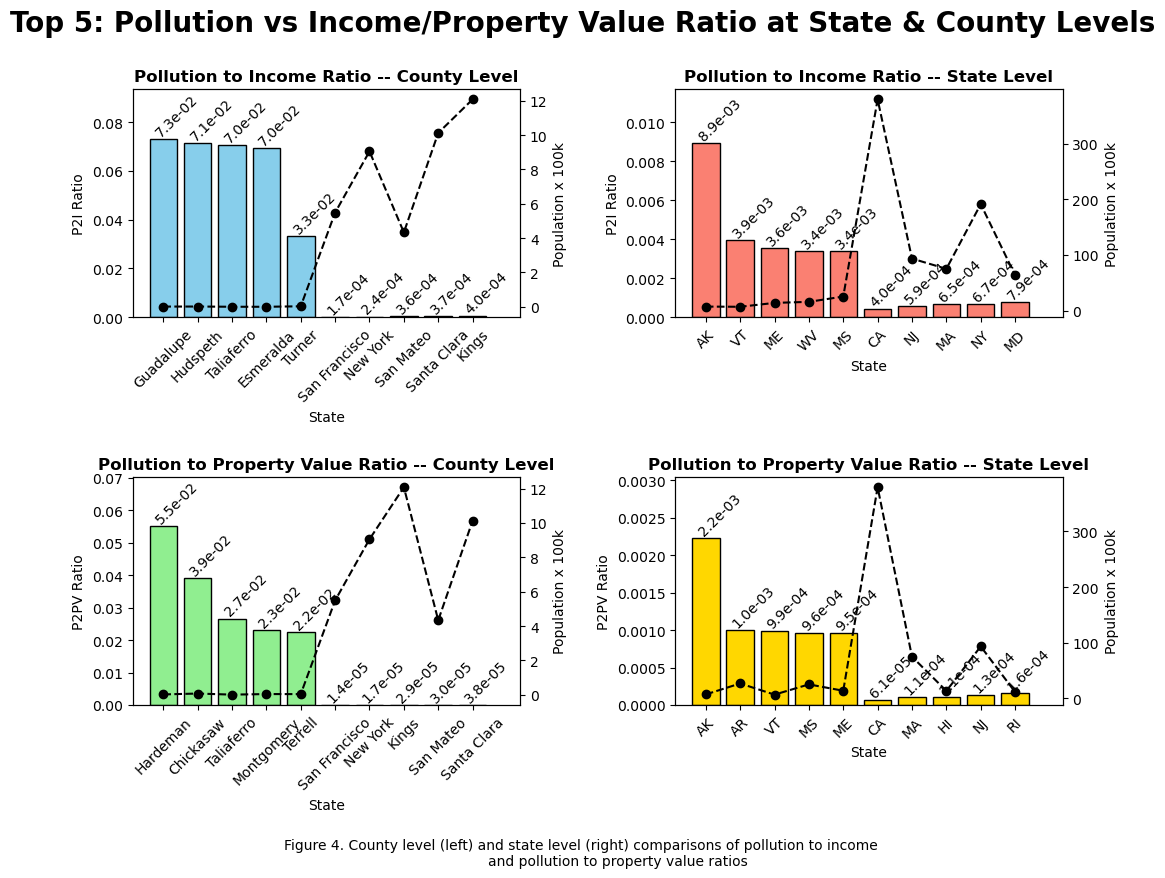

In [39]:
extreme_dfs = [county_extremes_PI, state_extremes_PI, county_extremes_PPV, state_extremes_PPV]
extremes_bar_plotter(extreme_dfs,4)

In [114]:
# Okay, so this is interesting. We see clearly that at the state level and at the county level, the locations with the
# greatest pollution relative to income are those which boast smaller populations, whilethose with the smallest 
# pollution to income ratios have quite large populations. 

# It's worth noting that the counties with the lowest pollution to income also have the lowest pollution to property 
# value. We see slight changes to this at the state level (swapping Maryland and New York for Hawaii and Rhode Island),
# but at the county level, the highest ratios are entirely different counties.

# We might be tempted to suggest that all small population areas have large rates of pollution to income or 
# property values, but we know by the law of small numbers that small sample sets can skew our representation. There's 
# likely a few low-population counties with very small pollution relative to income or property value.

# If we want to identify if there's a clear correlation between population density (rural vs urban), we can do this by
# making a correlation matrix or a SPLOM. For this project, we'll use a correlation matrix -- and we'll do that now. 

In [41]:
df_merged_cty.sample(2)

,STATE,STATE FIPS,COUNTY FIPS,COUNTY,Rural_Urban_Continuum_Code_2013,EMISSIONS,Civilian_labor_force_2021,Median_Household_Income_2021,Unemployment_rate_2021,median_sale_price,Emissions per Person,PI_ratio,PPV_ratio
929,NJ,34,035,Somerset,1.0,10693,175699.0,123708.0,5.4,450000.0,121.719532,0.000984,0.000270
1328,TN,47,013,Campbell,2.0,3819,14785.0,44325.0,5.0,203475.0,516.604667,0.011655,0.002539


### Correlation Matrix


In [48]:
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt

def plot_correlations(df, include_continuum=True, fig_num=5):
    """This function creates a correlation plot of the merged dataframe between per person CO emissions and variables
    like income, unemployment, property value, level of urbanization (Rural urban continuum code). The user inputs
    whether or not the entire continuum is included to adjust the number of squares in the heatmap."""

    correlation_list = ["Emissions per Person", 
                               "Median_Household_Income_2021", "Unemployment_rate_2021", "median_sale_price",
                               "Rural_Urban_Continuum_Code_2013"]
    
    if include_continuum == False:
        correlation_list = correlation_list[0:-1]
        print(correlation_list)
    elif include_continuum != True:
        raise ValueError("include_continuum must be boolean True or False") 
    
    corr_cols = df[correlation_list]
    corr = corr_cols.corr(method='spearman')


    # Plot the correlation heatmap using seaborn, cividis for colorblind, and setting to 2 decimal places
    plt.figure(figsize=(18, 10))
    color_map = sns.color_palette("coolwarm", as_cmap=True)
    sns.heatmap(corr, annot=True, cmap='cividis', fmt='.2f', facecolor='w')  # Change base color to white

    # Make x labels reader friendly
    custom_ticklabels = ["Emissions \nper Capita", 
                          "Median \nIncome", "Unemployment \nRate", "Property \nValue",
                          "Urbaniztion \nLevel"]

    if include_continuum == False:
        custom_ticklabels = custom_ticklabels[0:-1]
    
    plt.xticks(ticks=[x + 0.5 for x in range(len(custom_ticklabels))], labels=custom_ticklabels, fontsize=14,
               ha='center', rotation=0)
    plt.yticks(ticks=[y + 0.4 for y in range(len(custom_ticklabels))], labels=custom_ticklabels, fontsize=14,
               va='top') 

    # Set x-label font size
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)

    if include_continuum == False: 
        _string = "for RUC Code {}".format(int(df["Rural_Urban_Continuum_Code_2013"].iloc[0]))
    else: 
        _string = ""
    
    # Add a title with padding
    title = "Correlation: CO Emissions, Wealth Indicators, and Urbanization {}".format(_string)
    plt.title(title, fontsize=22, pad=20)

    # Add caption
    caption = """Figure {}: Spearman Correlation heatmap between per Capita CO emissions, wealth factors, 
    and urbanization level""".format(fig_num)
    
    plt.figtext(0.435, -0.02, caption, wrap=True, horizontalalignment='center', fontsize=14)

    plt.show()
    return() 


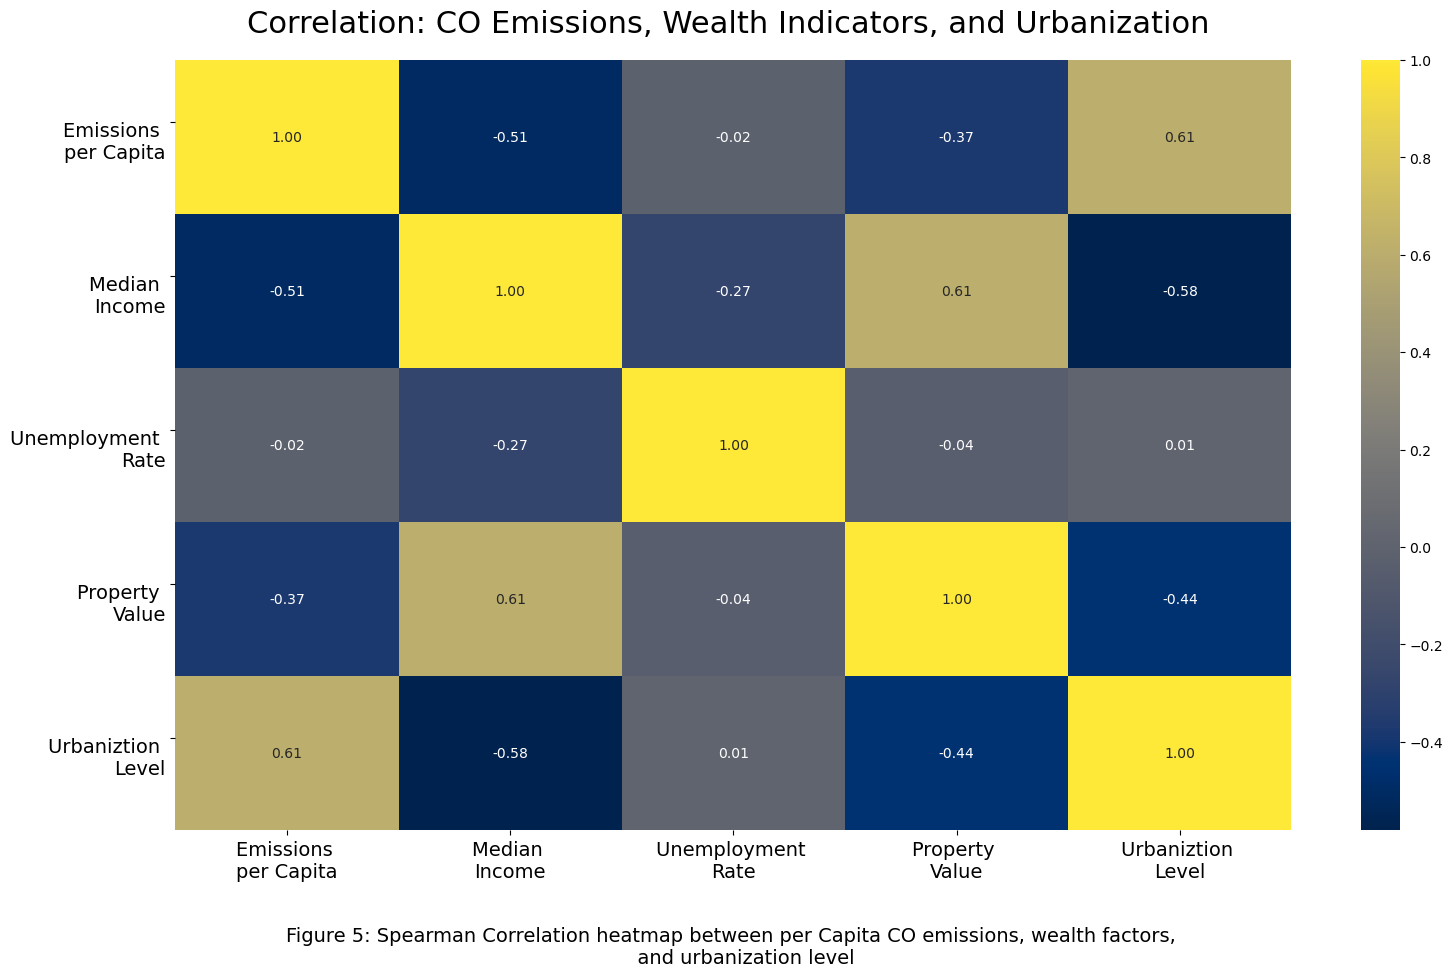

()

In [49]:
plot_correlations(df_merged_cty, include_continuum=True, fig_num=5)

In [21]:
# So this is really interesting. When we examine the various factors that could influence residential CO pollution 
# rates, it seems that the strongest correlative factor is the degree to which the location is in a rural or urban area 
# (Rural vs. Urban Continuum), where the higher the value or more rural the area, the greater the level of pollution 
# per person. This is suppported by the labor force variable which is negatively correlated with per person pollution.

# When we consider wealth factors like income, and property value, it actually seems like pollution decreases as wealth 
# increases, but we should verify that this is true when considering locations of similar population size and proximity
# to metropolitan regions. 

In [71]:
# Let's review how income and property value correlations to emissions change as we 
# control for particular population densities. 

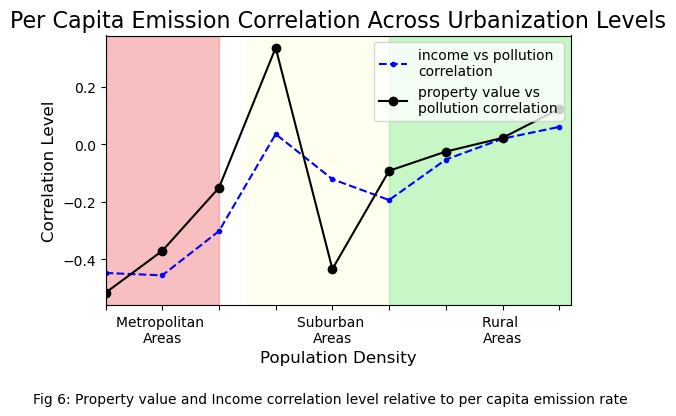

In [55]:
def controlled_urbanization_correlations(fig_num=6): 
    """This function iterates through each urbanization level to plot the spearman correlation value between
    per capita pollution rate and median income (or property value) at each urbanization level. One the plot, 
    X is the level of urbanization (left most urban, right most rural), and Y is the correlation value between the 
    two variables."""
    
    # Set let of correlation factors
    correlation_list = ["Emissions per Person", 
                           "Median_Household_Income_2021", "Unemployment_rate_2021", "median_sale_price",
                           "Rural_Urban_Continuum_Code_2013"]
    
    # Prepare to iterate through a series of dataframe correlations 
    counter = 0
    income_list = []
    property_list = []
    urbanization_continuum = list(set(df_merged_cty["Rural_Urban_Continuum_Code_2013"]))
    
    # Run the correlations and append to the associated list
    for val in set(df_merged_cty["Rural_Urban_Continuum_Code_2013"]):
        test_df = df_merged_cty[df_merged_cty["Rural_Urban_Continuum_Code_2013"]==val]
        corr_cols = test_df[correlation_list]
        test_df_corrs = corr_cols.corr(method='spearman')
        income_value = test_df_corrs["Median_Household_Income_2021"].loc["Emissions per Person"]
        property_value = test_df_corrs["median_sale_price"].loc["Emissions per Person"]
        income_list.append(income_value)
        property_list.append(property_value)

    # Set x,y for plotting 
    x = urbanization_continuum
    y1 = income_list
    y2 = property_list
    
    #Plot
    plt.figure(figsize=(6, 3.5))
    plt.plot(x,y1,'b.--',label="income vs pollution \ncorrelation")
    plt.plot(x,y2,'ko-',label="property value vs \npollution correlation")
    custom_tick_labels = ["","Metropolitan \nAreas",  "", "", "Suburban \nAreas", "", 
                          "",  "Rural \nAreas", ""]

    #Add title, custom ticks, and shading 
    plt.title("Per Capita Emission Correlation Across Urbanization Levels", fontsize=16)
    plt.xlabel("Population Density", fontsize=12)
    plt.ylabel("Correlation Level", fontsize=12)
    plt.xticks(x, custom_tick_labels, rotation = 0)  # Setting custom tick labels
    plt.axvspan(1, 3, alpha=0.5, color='lightcoral')
    plt.axvspan(3.5, 6, alpha=0.5, color='lightyellow')
    plt.axvspan(6, 11, alpha=0.5, color='lightgreen')
    
    #final formatting
    plt.xlim(1,9.2)
    plt.legend(loc='upper right')
    text = "Property value and Income correlation level relative to per capita emission rate"
    plt.figtext(0.5, -0.17, "Fig {}: {}".format(fig_num,text), ha="center", fontsize=10)
    plt.show()

controlled_urbanization_correlations(fig_num=6)

In [ ]:
# So this is really interesting. The only instance in which median household income at the county level is positively 
# correlated with CO pollution generation is when the they live in the most isolated areas of the United States. 

# Meanwhile, in suburban areas we see residential emissions for the general public are not that well correlated with 
# income or property value, but there is moderate correlation with metropolitan areas. 

# Importantly though, that's not to say that wealthy people are generally more environmentally friendly than poor people. 
# Remember that incentives have existed for years, where wealthier individuals have been taking advantage of emission 
# reducing technologies at a frequency greater than their peers. Also, perhaps other factors are influencing this. 
# The cost of living for example could play a role, where your carbon footprint in San Francisco/NYC is lower than 
# Smallville, Kansas. 

# Likewise, our analysis does not include air traffic emissions. We could include it, but we lack information
# needed to de-couple freight travel from public leisure travel. So this does not capture the whole picture, 
# but it's a good first estimate. 

In [ ]:
# The last thing we're going to do in this notebook is revisit our emission distributions. Now that we have population
# data to normalize them across. Let's see how emission generation rates are distributed. 

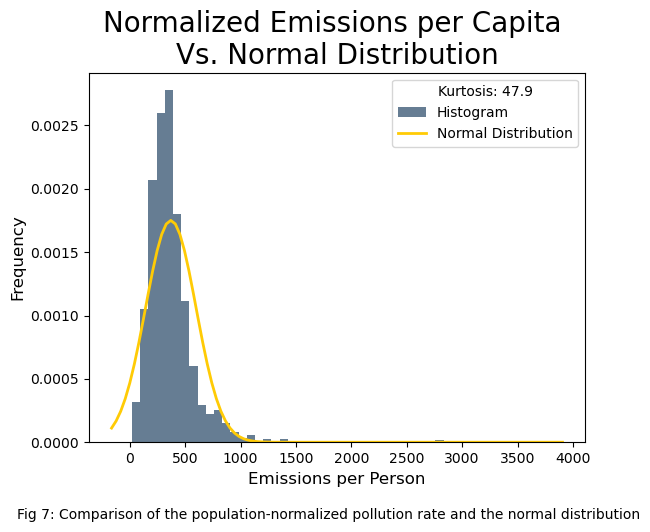

In [78]:
def norm_emission_plotter(fig_num=7):
    """This function generates a histogram based on the population-normalized emission rate, and 
    overlays a normal distribution to check how pollution rates are distributed. The kurtosis is also """

    # Import packages 
    from scipy.stats import norm, kurtosis, shapiro

    data = df_merged_cty["Emissions per Person"]

    # Plot histogram in UM blue
    plt.hist(data, bins=50, density=True, alpha=0.6, color='#01274C', label='Histogram')  # UM blue

    # Fit a normal distribution to the data, based on the probability density function
    mu, std = norm.fit(data)
    xmin, xmax = plt.xlim()
    x = np.linspace(xmin, xmax, 100)
    p = norm.pdf(x, mu, std)

    # Plot normal distribution curve in UM maize
    plt.plot(x, p, color='#FFCB05', linewidth=2, label='Normal Distribution')  # UM maize

    # Calculate kurtosis and Shapiro-Wilks statistic
    kurt = kurtosis(data)

    # Add kurtosis, Shapiro-Wilks statistic, and p-value to legend using f-string formatting
    plt.legend(loc='upper right', fontsize=10, 
               title=f'Kurtosis: {kurt:.1f}')

    plt.title('Normalized Emissions per Capita \nVs. Normal Distribution', fontsize=20)
    plt.xlabel('Emissions per Person',fontsize=12)
    plt.ylabel('Frequency',fontsize=12)
    text = "Comparison of the population-normalized pollution rate and the normal distribution"
    plt.figtext(0.5, -0.05, "Fig {}: {}".format(fig_num,text), ha="center", fontsize=10)
    plt.show()
norm_emission_plotter(fig_num=7)

In [ ]:
# So this is interesting. We see that our emissions still don't represent a normal distribution, even when 
# considering population differences in each region. This could indicate labor force is a poor estimate 
# for total population, or it could suggest that emission generate rates are non-uniform across the U.S. 

In [12]:
# Now we still haven't answered our last question. How are emissions stratified by sector for different populations? 
# Perhaps we'll see unique differences in pollution rates between wealthier and poorer locations when we stratify this. 
# In the next notebook, we're going to probe this, as well as geographical distributions of pollution by the various 
# factors. 

### End of Notebook

Next notebook: Multivariate Analysis: Sectoral Distributions and Geographic Choropleths

---